In [163]:
import pyaudio
import wave
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import sys
sys.path.insert(1, '../')
from Utilities import *
from IPython.display import Audio, display, Image


def record_sample():

    chunk = 1024  # Record in chunks of 1024 samples
    sample_format = pyaudio.paInt16  # 16 bits per sample
    channels = 1
    fs = 16000  
    seconds = 1
    filename = "output.wav"

    p = pyaudio.PyAudio()  # Create an interface to PortAudio

    print('Recording in 3,')
    time.sleep(1)
    print('Recording in 2,')
    time.sleep(1)
    print('Recording in 1,')
    time.sleep(1)
    print('Recording...')

    stream = p.open(format=sample_format,
                    channels=channels,
                    rate=fs,
                    frames_per_buffer=chunk,
                    input=True)

    frames = []  # Initialize array to store frames

    # Store data in chunks for 3 seconds
    for i in range(0, int(fs / chunk * seconds)):
        data = stream.read(chunk)
        frames.append(data)

    # Stop and close the stream 
    stream.stop_stream()
    stream.close()
    # Terminate the PortAudio interface
    p.terminate()

    print('Finished recording')

    # Save the recorded data as a WAV file
    wf = wave.open(filename, 'wb')
    wf.setnchannels(channels)
    wf.setsampwidth(p.get_sample_size(sample_format))
    wf.setframerate(fs)
    wf.writeframes(b''.join(frames))
    wf.close()
    
    
    
    

def continuous_detection():
    with tf.device("/cpu:0"):
#     model = AttRNNSpeechModel80K((80, 126, 1), classes)

#     model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

        model = tf.keras.models.load_model('ModelEntireDatasetPartitioned_AttRNNSpeechModel80K_0.512_cl.h5')

        #model.summary()
        CHUNKSIZE = 8000 # fixed chunk size
        RATE = 16000
        sr = 16000
        first = True
        sample = 0
        # initialize portaudio
        p = pyaudio.PyAudio()
        stream = p.open(format=pyaudio.paFloat32, channels=1, rate=RATE, input=True, frames_per_buffer=CHUNKSIZE)
        
        data = stream.read(2*CHUNKSIZE)
        noise_sample = np.frombuffer(data, dtype=np.float32)
        
        print("Noise Sample")
        loud_threshold = np.mean(np.abs(noise_sample))*5
        print("Loud threshold", loud_threshold)

        previous_chunk = np.zeros(8000)
        now = time.time()
        future = now + 5
        
        while(time.time() < future):
            data = stream.read(CHUNKSIZE)
            data = np.frombuffer(data, dtype=np.float32)
            
            if(first):
                previous_chunk=data
                first = False
            else:
                sample += 1
                current_sample = np.concatenate((previous_chunk,data))
               # print(np.mean(np.abs(current_sample)))
                if(np.mean(np.abs(current_sample))<loud_threshold):
                   a=1 
#                  print("sample ", sample, ' = ', end='')
#                  print("silence noise")
                 
                else:
                    #librosa.display.waveplot(current_sample, sr=RATE)
                    #plt.close('all')
                    y = normalize_data(current_sample)
                    librosa_melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024,
                                                             hop_length=128, power=1.0,  # window='hann',
                                                             n_mels=80, fmin=40.0, fmax=sr / 2)

                    S_dB = librosa.power_to_db(librosa_melspec, ref=np.max)


                    S_dB = S_dB.reshape((S_dB.shape[0], S_dB.shape[1], 1))
                    result = normalize_data(S_dB)
                    spectrogram=np.resize(result,(1,80,126,1))

                    prediction = model.predict(spectrogram)
    #                 print(prediction)
                    print("sample ", sample, ' = ', end='')
                    print(dict[np.argmax(prediction)],' with probability ', np.max(prediction))
#                     if(dict[np.argmax(prediction)]!= "silence"):
#                         break
#                     if np.max(prediction)>0.90:
#                         print(dict[np.argmax(prediction)])
#                     else:
#                         print("silence")
                    previous_chunk = data



        # close stream
        stream.stop_stream()
        stream.close()
        p.terminate()
    print("end")
    
classes=12
dict={
    0 : "down", 
    1 : "go",
    2 : "left",
    3 : "no",
    4 : "off",
    5 : "on",
    6 : "right",
    7 : "stop",
    8 : "up",
    9 : "yes",
    10 : "silence",
    11 : "unknown"
}

dataset_path = '../speech_commands_v0.02/'
task_selected="12_cl"
masking_fraction_train = 0.0

if task_selected == "12_cl":
    classes = 12
elif task_selected == "35_cl":
    classes = 35

train_reference, validation_reference, test_reference = import_datasets_reference('train_dataset.txt', 'validation_dataset.txt', 'real_test_dataset.txt',  masking_fraction_train=masking_fraction_train, task_selected=task_selected)

numToClass, classToNum = generate_classes_dictionaries(dataset_path, task_selected)

# change label from string to int
test_reference['label'] = test_reference['label'].apply(lambda l: classToNum[l])

batch_size = 32
test_steps = int(np.ceil(len(test_reference) / batch_size))

test_dataset = create_dataset(test_reference, batch_size, shuffle=False, filter=False, repeat=False, cache_file='../test_cache'+task_selected)


TypeError: import_datasets_reference() got multiple values for argument 'masking_fraction_train'

In [157]:
# go, stop - left, right - on, off - yes, no - up, down
continuous_detection()

Noise Sample
Loud threshold 0.02192119136452675
end


In [150]:
record_sample()


Recording in 3,
Recording in 2,
Recording in 1,
Recording...
Finished recording


In [2]:
y, sr = librosa.load("output.wav", 16000)

Audio(data=y, rate=sr)

(80, 126, 1)


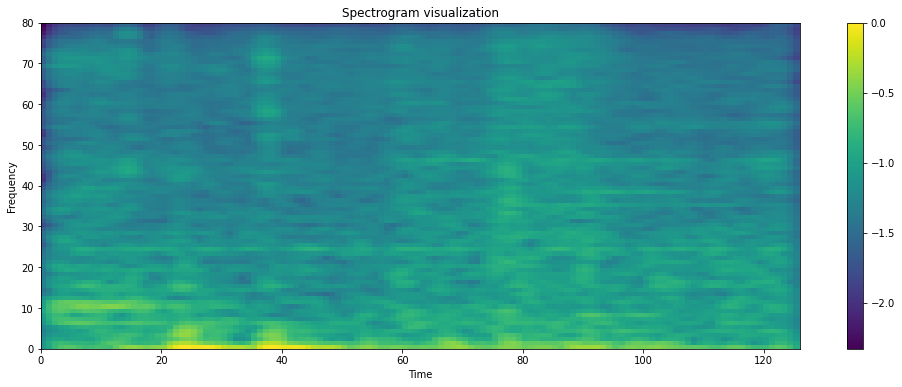

Model: "AttRNNSpeechModel80K"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 126, 1)] 0                                            
__________________________________________________________________________________________________
permute (Permute)               (None, 126, 80, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 40, 32)   320         permute[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 40, 32)   128         conv2d[0][0]                     
_______________________________________________________________________________

In [159]:


spectrogram = load_and_preprocess_data_librosa_mel_spectrogram("output.wav")

print(spectrogram.shape)
plt.figure(figsize=(17, 6))
plt.pcolormesh(spectrogram[:,:,0])
plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.colorbar()
plt.show()

# with tf.device("/cpu:0"):
#     model = AttRNNSpeechModel80K((80, 126, 1), classes)

#     model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model = tf.keras.models.load_model('ModelEntireDatasetPartitioned_AttRNNSpeechModel80K_0.512_cl.h5')

model.summary()

In [4]:
spectrogram=np.resize(spectrogram,(1,80,126,1))
with tf.device("/cpu:0"):
    prediction = model.predict(spectrogram)

print(prediction)

[[2.6820567e-06 9.9900812e-01 9.7727082e-08 6.1572988e-05 1.3697664e-06
  2.0819009e-06 5.4158392e-07 2.3819595e-07 9.2094386e-05 3.1382626e-06
  3.9301409e-10 8.2811754e-04]]


In [5]:
print(dict[np.argmax(prediction)])
print(np.max(prediction))


go
0.9990081
